In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!sudo apt install tesseract-ocr -y

In [ ]:
!sudo apt-get install python3-tk python3-dev -y

In [27]:
!pip install mss pyautogui pytesseract

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from mss import mss
import pyautogui
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
# #just testing dimensions

# game_location = {'top': 125, 'left': 50, 'width': 60, 'height': 50}
# img = mss().grab(game_location)
# img = cv2.resize(np.array(img)[:, :, :3], (0, 0), fx=8, fy=8)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# thr = cv2.cvtColor(cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], cv2.COLOR_BGR2RGB)
# plt.imshow(cv2.cvtColor(thr, cv2.COLOR_BGR2RGB))
# pytesseract.image_to_string(thr, config="--psm 10 -c page_separator=''")

In [66]:
# play the game but can be ignored for now

# env = WebGame()

# for episode in range(1):
#     obs = env.reset()
#     terminated = False
#     total_reward = 0
# #     obs, reward, terminated, truncated, info =  env.step(3)
# #     obs, reward, terminated, truncated, info =  env.step(1)
#     while not terminated:
#         action = model.predict(obs[0].reshape((1, 100, 100)))
#         # print(action)
#         obs, reward, terminated, truncated, info =  env.step(int(action[0]))
#         total_reward  += reward
# #         if reward != 0:
# #             print(terminated, env.get_score(), reward)
#     print('Total Reward for episode {} is {}'.format(episode, total_reward))   

Total Reward for episode 0 is 1


In [37]:
# ! pip install stable_baselines3[extras]

In [2]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [58]:
env_checker.check_env(env)

In [4]:
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [5]:
CHECKPOINT_DIR = './train/post'
LOG_DIR = './logs/post'

In [6]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

In [ ]:
# !pip install stable-baselines3[extra]

1. Initialize previous_score in the constructor to keep track of the previous score.

2. Calculate the reward based on whether the agent collected an apple or if the game is done (collided or game over).

3. Update previous_score after calculating the reward to ensure consistency.

4. Convert the score string obtained from OCR to an integer to correctly track the score.

In [54]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1, 100, 100), dtype=np.uint8)
        self.action_space = Discrete(4)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 100, 'left': 0, 'width': 600, 'height': 600}
        self.done_location = {'top': 600, 'left': 635, 'width': 75, 'height': 50}
        self.score_location = {'top': 125, 'left': 50, 'width': 60, 'height': 50}
        self.previous_score = "0\n"  # Initialize previous_score

    def step(self, action):
        action_map = {
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right'
        }
        prev_observation = self.get_observation()
        pyautogui.press(action_map[action])

        # We calculate reward based on collecting apples and avoiding collisions
        reward = 0
        done, _ = self.get_done()  # Now get done status
        
        current_score = self.get_score()
        
        if current_score != self.previous_score:
            reward += 1  # Positive reward for collecting an apple
        if done:
            reward -= 1  # Negative reward for colliding or game over

        # Update the previous_score
        self.previous_score = current_score

        observation = self.get_observation()

        info = {}

        return observation, reward, done, False, info

    def reset(self, **kwargs):
        self.previous_score = "0\n" 
        time.sleep(0.5)
        pyautogui.click(x=600, y=600)
        time.sleep(0.5)
        pyautogui.press('up')
        self.frame = 2

        return self.get_observation(), {}  # Return the initial observation

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 100))
        channel = np.reshape(resized, (1, 100, 100))
        return channel

    def get_score(self):
        score_cap = np.array(self.cap.grab(self.score_location))[:, :, :3]
        img = cv2.resize(score_cap, (0, 0), fx=8, fy=8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thr = cv2.cvtColor(cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], cv2.COLOR_BGR2RGB)
        score_string = pytesseract.image_to_string(thr, config="--psm 10 -c page_separator=''")
        
        # Convert the score string to an integer
#         try:
#             score = int(score_string)
#         except ValueError:
#             score = 0

        return score_string

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        img = cv2.resize(done_cap, (0, 0), fx=8, fy=8)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thr = cv2.cvtColor(cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1], cv2.COLOR_BGR2RGB)
        done = False
        res = pytesseract.image_to_string(thr)
        if 'play' in res.lower():
            done = True
        return done, done_cap


In [45]:
from stable_baselines3 import PPO, DQN

In [57]:
env = WebGame()

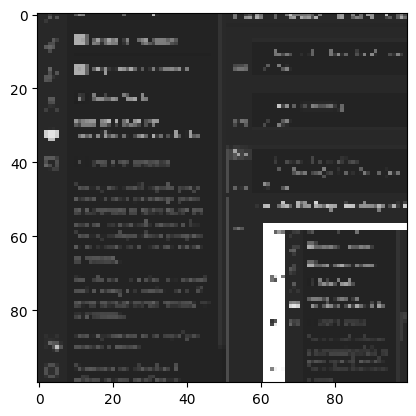

In [79]:
# show observation
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [80]:
# trial to do some kind of resnet but I've also tried making the NatureCNN from the SB3 website wider and denser

from torch import nn
import torch as th
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CNNPart(nn.Module):
    def __init__(self, n_input_channels):
        super().__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv2d(n_input_channels, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128), 
            nn.ReLU(),)
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),)
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(128),  
            nn.ReLU(),)
        
        self.pool = nn.AvgPool2d(2, 2)
    
    def forward(self, x):
        x1 = self.pool(self.convblock1(x))
        x2 = self.pool(self.convblock2(x1))
        x3 = self.convblock3(x2) + x2 + self.pool(x1)
        return nn.Flatten()(x3)
    

class CustomNatureCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super().__init__(observation_space, features_dim)

        n_input_channels = observation_space.shape[0]
        
        self.cnn = CNNPart(n_input_channels)

        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim * 4),  # New Layer
            nn.BatchNorm1d(features_dim * 4),  # New Layer
            nn.ReLU(),  # New Layer
            
            nn.Linear(features_dim * 4, features_dim * 2),
            nn.BatchNorm1d(features_dim * 2),  # Added BatchNorm
            nn.ReLU(),
            
            nn.Linear(features_dim * 2, features_dim),  # New Layer
            nn.BatchNorm1d(features_dim),  # New Layer
            nn.ReLU(),  # New Layer
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.linear(x)

In [59]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0003, n_steps=128, ent_coef=0.01, gamma=0.97)#, policy_kwargs=dict(features_extractor_class=CustomNatureCNN))
# model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [60]:
model.learn(total_timesteps=25000, callback=callback)  # Increase the total timesteps

Logging to ./logs/post/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.3     |
|    ep_rew_mean     | -0.818   |
| time/              |          |
|    fps             | 2        |
|    iterations      | 1        |
|    time_elapsed    | 58       |
|    total_timesteps | 128      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | -0.909      |
| time/                   |             |
|    fps                  | 2           |
|    iterations           | 2           |
|    time_elapsed         | 116         |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.010537297 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0487      |
|

In [ ]:
model = PPO.load('./train/post/best_model_10000.zip', env)

In [62]:
!tensorboard --logdir=logs/post/PPO_1

TensorFlow installation not found - running with reduced feature set.
/home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
/home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
/home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/vini_suaiden/.local/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [61]:
!ls logs/post

PPO_1
